In [1]:
pkg load image

#### Funcion de Binarizacion

In [2]:
function bin=toGray(img)
    bin = uint8(rgb2gray(img));
end

In [3]:
function output = Binarization(imD,threshold);

    [fBin,cBin]=size(imD);

    for i=1:fBin
        for j=1:cBin
            if imD(i,j)<=threshold
                imageBin(i,j) = 0;
            else
                imageBin(i,j) = 255;
            end
        end
    end

    output = imageBin;
end

#### Funcion Histograma e Histograma Normalizado

In [4]:
function hist=Histograma(img)
    %El histograma va desde los tonos negros hasta tonos blancos.
    imD = double(img);
    [f,c]=size(imD);

    for i=1:256
        h(i) = 0;
    end

    for i=1:f
           for j=1:c
               k = imD(i,j);
               h(k+1) = h(k+1)+1;
           end
    end
    %Plotear el Histograma
    %plot(h);
    hist = h;
end

In [5]:
function hN=histNormalizado(matrix)

hist = Histograma(matrix);
[f,c]=size(matrix);

hN = hist / (f * c);
end

#### Metodo Otsu

In [6]:
function umbral=otsu(matrix)
    [f,c] = size(matrix);
    hN = histNormalizado(matrix);

    mayor = -1;
    umbral = -1;

    for t=1:256
        w1 = 1e-16;
        u1 = 1e-16; u2 = 1e-16;
        for i=1:t
            w1 = w1 + double(hN(i));
        end
        w2 = 1 - w1;
        
        if w2 == 0
            w2 = 1e-16;
        end

        for i=1:t
            c1 = (hN(i)/w1);
            u1 = u1 + c1*i;
        end
        for i=t+1:256
            c2 = (hN(i)/w2);
            u2 = u2 + c2*i;
        end
        ut = w1*u1 + w2*u2;

        B = w1*(u1 - ut)^2 + w2*(u2 - ut)^2;
        if(B > mayor)
            mayor = B;
            umbral = t;
        end
    end
end

#### Metodo Kappur

In [7]:
function umbral=kapurMethod(imD);
    [f,c]=size(imD);
    mayor = -1;
    umbral = 0;
    
    hn = histNormalizado(imD);

    for t=1:256
        pt = 0;
        pr = 0;
        s1 = 0;
        s2 = 0;
        eObjeto = 0;
        eFondo = 0;
        entropiaT = 0;
        %CALCULO PARA EL OBJETO
        for j=1:t
            pt = pt + hn(j);
        end 
        for i=1:t
            if pt~=0
                s1 = hn(i)/pt;
            end
            if s1~=0
                eObjeto = eObjeto + (s1)*log2(s1);
            end
        end
        %CALCULO PARA EL FONDO
        pr = 1 - pt;
        for i=t+1:256
            if pr~=0 && pt~=0
                s2 = hn(i)/pr;
            end
            if s2~=0
                eFondo = eFondo + (s2)*log2(s2);
            end
        end

        entropiaT = -eObjeto + -eFondo;
        if (entropiaT > mayor )
            mayor = entropiaT;
            umbral = t-1;
        end
    end
end

#### Metodo Isodata

In [8]:
function salida = kernel_isodata(t,h)

    hP = zeros(1,256);

    for j = 1:256
         hP(j) = h(j)*(j);
    end

    shN = 0;
    shP = 0;
    shNL = 0;
    shPL = 0;

    for i = 1:t
       shN = shN + h(i);
       shP = shP + hP(i);
    end

    for i = t+1:256
       shNL = shNL + h(i);
       shPL = shPL + hP(i);
    end

    if (shN == 0 || shNL == 0)
        uj = 1;
    else    
        uj = ((shP/shN) + (shPL/shNL))/2;
    end

    salida = uj;
end

In [9]:
function umbral = isodata(imagen)
    hn = histNormalizado(imagen);
    u = zeros(1,256);

    for i=1:256
        u(i) = kernel_isodata(i,hn);  
    end

    i = 2;
    while (abs(u(i)-u(i-1)) >= 1 || u(i)==1)
        i = i+1;   
    end

    umbral = u(i);
end

#### Filtro de Promediacion

In [10]:
function image=averagefilter(image, varargin)
    numvarargs = length(varargin);
    if numvarargs > 2
        error('myfuns:somefun2Alt:TooManyInputs', ...
            'requires at most 2 optional inputs');
    end

    optargs = {[3 3] 0};            % set defaults for optional inputs
    optargs(1:numvarargs) = varargin;
    [window, padding] = optargs{:}; % use memorable variable names
    m = window(1);
    n = window(2);
    if ~mod(m,2) m = m-1; end       % check for even window sizes
    if ~mod(n,2) n = n-1; end
    if (ndims(image)~=2)            % check for color pictures
        display('The input image must be a two dimensional array.')
        display('Consider using rgb2gray or similar function.')
        return
    end
    % Initialization.
    [rows columns] = size(image);   % size of the image
    % Pad the image.
    imageP  = padarray(image, [(m+1)/2 (n+1)/2], padding, 'pre');
    imagePP = padarray(imageP, [(m-1)/2 (n-1)/2], padding, 'post');
    % Always use double because uint8 would be too small.
    imageD = double(imagePP);
    % Matrix 't' is the sum of numbers on the left and above the current cell.
    t = cumsum(cumsum(imageD),2);
    % Calculate the mean values from the look up table 't'.
    imageI = t(1+m:rows+m, 1+n:columns+n) + t(1:rows, 1:columns)...
        - t(1+m:rows+m, 1:columns) - t(1:rows, 1+n:columns+n);
    % Now each pixel contains sum of the window. But we want the average value.
    imageI = imageI/(m*n);
    % Return matrix in the original type class.
    image = cast(imageI, class(image));
end

#### Metodo Sauvola

In [11]:
function output=sauvola(imagen, varargin)
    image=imagen;
    % Initialization
    numvarargs = length(varargin);      % only want 3 optional inputs at most
    if numvarargs > 3
        error('myfuns:somefun2Alt:TooManyInputs', ...
         'Possible parameters are: (image, [m n], threshold, padding)');
    end

    optargs = {[3 3] 0.34 'replicate'}; % set defaults

    optargs(1:numvarargs) = varargin;   % use memorable variable names
    [window, k, padding] = optargs{:};
    if ndims(image) ~= 2
        error('The input image must be a two-dimensional array.');
    end
    % Convert to double
    image = double(image);
    % Mean value
    mean = averagefilter(image, window, padding);
    % Standard deviation
    meanSquare = averagefilter(image.^2, window, padding);
    deviation = (meanSquare - mean.^2).^0.5;
    % Sauvola
    R = max(deviation(:));
    threshold = mean.*(1 + k * (deviation / R-1));
    output = (image > threshold);
end

#### Metodo Niblack

In [12]:
function output = niblack(image, varargin)
    % Initialization
    numvarargs = length(varargin);      % only want 4 optional inputs at most
    if numvarargs > 4
        error('myfuns:somefun2Alt:TooManyInputs', ...
         'Possible parameters are: (image, [m n], k, offset, padding)');
    end

    optargs = {[3 3] -0.2 0 'replicate'};   % set defaults

    optargs(1:numvarargs) = varargin;   % use memorable variable names
    [window, k, offset, padding] = optargs{:};
    if ndims(image) ~= 2
        error('The input image must be a two-dimensional array.');
    end
    % Convert to double
    image = double(image);
    % Mean value
    mean = averagefilter(image, window, padding);
    % Standard deviation
    meanSquare = averagefilter(image.^2, window, padding);
    deviation = (meanSquare - mean.^2).^0.5;
    % Initialize the output
    output = zeros(size(image));
    % Niblack
    output(image > mean + k * deviation - offset) = 1;
end

#### Lineazadores

In [13]:
function [S, shape] = parse_inputsFILT(varargin)
    shape = 'same';
    flag = [0 0]; % size shape
    for i = 1 : nargin
       t = varargin{i};
       if strcmp(t,'full') && flag(2) == 0
          shape = 'full';
          flag(2) = 1;
       elseif strcmp(t,'same') && flag(2) == 0
          shape = 'same';
          flag(2) = 1;
       elseif strcmp(t,'valid') && flag(2) == 0
          shape = 'valid';
          flag(2) = 1;
       elseif flag(1) == 0
          S = t;
          flag(1) = 1;
       else
          error(['Too many / Unkown parameter : ' t ])
       end
    end
    if flag(1) == 0
       S = [3 3];
    end
    if length(S) == 1;
       S(2) = S(1);
    end
    if length(S) ~= 2
       error('Wrong window size parameter.')
    end
end

In [14]:
function [direc, shape] = parse_inputsVAR(varargin)
    direc = 'lin';
    shape = 'same';
    flag = [0 0]; % [dir shape]
    for i = 1 : nargin
       t = varargin{i};
       if strcmp(t,'col') && flag(1) == 0
          direc = 'col';
          flag(1) = 1;
       elseif strcmp(t,'full') && flag(2) == 0
          shape = 'full';
          flag(2) = 1;
       elseif strcmp(t,'same') && flag(2) == 0
          shape = 'same';
          flag(2) = 1;
       elseif strcmp(t,'valid') && flag(2) == 0
          shape = 'valid';
          flag(2) = 1;
       else
          error(['Too many / Unkown parameter : ' t ])
       end
    end
end

#### Kernel Optimizado de aplicacion de mascaras

In [15]:
function Y = vanherk(X,N,TYPE,varargin)
    % Initialization
    [direc, shape] = parse_inputsVAR(varargin{:});
    if strcmp(direc,'col')
       X = X';
    end
    if strcmp(TYPE,'max')
       maxfilt = 1;
    elseif strcmp(TYPE,'min')
       maxfilt = 0;
    else
       error([ 'TYPE must be ' char(39) 'max' char(39) ' or ' char(39) 'min' char(39) '.'])
    end
    % Correcting X size
    fixsize = 0;
    addel = 0;
    if mod(size(X,2),N) ~= 0
       fixsize = 1;
       addel = N-mod(size(X,2),N);
       if maxfilt
          f = [ X zeros(size(X,1), addel) ];
       else
          f = [X repmat(X(:,end),1,addel)];
       end
    else
       f = X;
    end
    lf = size(f,2);
    lx = size(X,2);
    clear X
    % Declaring aux. mat.
    g = f;
    h = g;
    % Filling g & h (aux. mat.)
    ig = 1:N:size(f,2);
    ih = ig + N - 1;
    g(:,ig) = f(:,ig);
    h(:,ih) = f(:,ih);
    if maxfilt
       for i = 2 : N
          igold = ig;
          ihold = ih;

          ig = ig + 1;
          ih = ih - 1;

          g(:,ig) = max(f(:,ig),g(:,igold));
          h(:,ih) = max(f(:,ih),h(:,ihold));
       end
    else
       for i = 2 : N
          igold = ig;
          ihold = ih;

          ig = ig + 1;
          ih = ih - 1;

          g(:,ig) = min(f(:,ig),g(:,igold));
          h(:,ih) = min(f(:,ih),h(:,ihold));
       end
    end
    clear f
    % Comparing g & h
    if strcmp(shape,'full')
       ig = [ N : 1 : lf ];
       ih = [ 1 : 1 : lf-N+1 ];
       if fixsize
          if maxfilt
             Y = [ g(:,1:N-1)  max(g(:,ig), h(:,ih))  h(:,end-N+2:end-addel) ];
          else
             Y = [ g(:,1:N-1)  min(g(:,ig), h(:,ih))  h(:,end-N+2:end-addel) ];
          end
       else
          if maxfilt
             Y = [ g(:,1:N-1)  max(g(:,ig), h(:,ih))  h(:,end-N+2:end) ];
          else
             Y = [ g(:,1:N-1)  min(g(:,ig), h(:,ih))  h(:,end-N+2:end) ];
          end
       end

    elseif strcmp(shape,'same')
       if fixsize
          if addel > (N-1)/2
             ig = [ N : 1 : lf - addel + floor((N-1)/2) ];
             ih = [ 1 : 1 : lf-N+1 - addel + floor((N-1)/2)];
             if maxfilt
                Y = [ g(:,1+ceil((N-1)/2):N-1)  max(g(:,ig), h(:,ih)) ];
             else
                Y = [ g(:,1+ceil((N-1)/2):N-1)  min(g(:,ig), h(:,ih)) ];
             end
          else   
             ig = [ N : 1 : lf ];
             ih = [ 1 : 1 : lf-N+1 ];
             if maxfilt
                Y = [ g(:,1+ceil((N-1)/2):N-1)  max(g(:,ig), h(:,ih))  h(:,lf-N+2:lf-N+1+floor((N-1)/2)-addel) ];
             else
                Y = [ g(:,1+ceil((N-1)/2):N-1)  min(g(:,ig), h(:,ih))  h(:,lf-N+2:lf-N+1+floor((N-1)/2)-addel) ];
             end
          end            
       else % not fixsize (addel=0, lf=lx) 
          ig = [ N : 1 : lx ];
          ih = [ 1 : 1 : lx-N+1 ];
          if maxfilt
             Y = [  g(:,N-ceil((N-1)/2):N-1) max( g(:,ig), h(:,ih) )  h(:,lx-N+2:lx-N+1+floor((N-1)/2)) ];
          else
             Y = [  g(:,N-ceil((N-1)/2):N-1) min( g(:,ig), h(:,ih) )  h(:,lx-N+2:lx-N+1+floor((N-1)/2)) ];
          end
       end      

    elseif strcmp(shape,'valid')
       ig = [ N : 1 : lx];
       ih = [ 1 : 1: lx-N+1];
       if maxfilt
          Y = [ max( g(:,ig), h(:,ih) ) ];
       else
          Y = [ min( g(:,ig), h(:,ih) ) ];
       end
    end
    if strcmp(direc,'col')
       Y = Y';
    end
end

#### Filtrado de Minimos

In [16]:
function Y = minfilt2(X,varargin)
    % Initialization
    [S, shape] = parse_inputsFILT(varargin{:});
    % filtering
    Y = vanherk(X,S(1),'min',shape);
    Y = vanherk(Y,S(2),'min','col',shape);
end

#### Filtrado de Maximos

In [17]:
function Y = maxfilt2(X,varargin)
    % Initialization
    [S, shape] = parse_inputsFILT(varargin{:});
    % filtering
    Y = vanherk(X,S(1),'max',shape);
    Y = vanherk(Y,S(2),'max','col',shape);
end

#### Metodo Bernsen

In [18]:
function output = bernsen(image, varargin)

    % Initialization
    numvarargs = length(varargin);      % only want 3 optional inputs at most
    if numvarargs > 3
        error('myfuns:somefun2Alt:TooManyInputs', ...
         'Possible BERNSEN parameters are: (image, [m n], contrast, padding)');
    end

    optargs = {[3 3] 15 'replicate'};   % set defaults

    optargs(1:numvarargs) = varargin;   % use memorable variable names
    [window, contrast_threshold, padding] = optargs{:};
    if ndims(image) ~= 2
        error('The input image must be a two-dimensional array.');
    end
    if sum(mod(window,2))~=2
        error('Sorry, only odd valued window dimensions are supported');
    end
    % Convert to double
    image = double(image);
    % Mean value
    mean = averagefilter(image, window, padding);
    % Local contrast
    local_contrast = maxfilt2(image, window) - minfilt2(image, window);
    % Initialize the output
    output = zeros(size(image));
    % Whenever contrast in the window is low assume homogenous area
    mask = local_contrast < contrast_threshold;
    output(mask && image>=128) = 1;
    % Otherwise compare to the mean value
    output(~mask) = (image(~mask) >= mean(~mask));
end

#### Comparativa y Ejecucion de los Metodos

In [19]:
!ls "../images" | cut -f 1 -d " " | awk '{print "\"" $1 "\"" ","}'

"boat.png",
"cameraman.png",
"coins.png",
"hands1.png",
"house.png",
"imagen1.png",
"imagen2.png",
"parrot.png",
"pout.png",
"westconcordorthophoto.png",



In [20]:
PATH = "../images";
IMGS = {
"boat.png",
"cameraman.png",
"coins.png",
"hands1.png",
"house.png",
"imagen1.png",
"imagen2.png",
"parrot.png",
"pout.png",
"westconcordorthophoto.png"
}';

In [21]:
results = zeros(size(IMGS)(2), (3 + (3 * 3)));

DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match
DEBUG: FC_WEIGHT didn't match


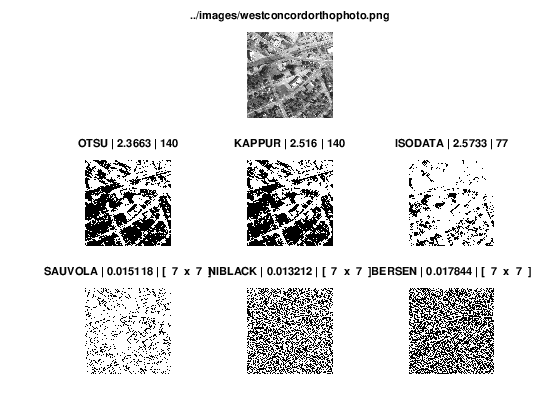

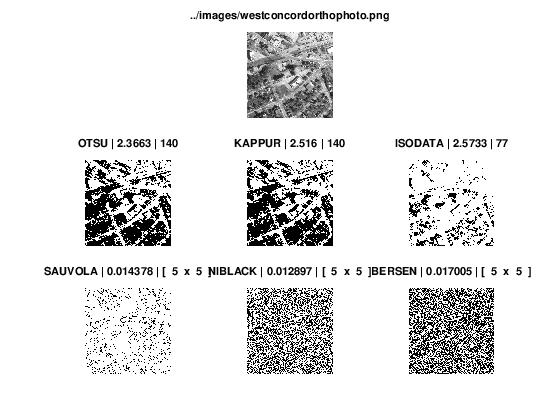

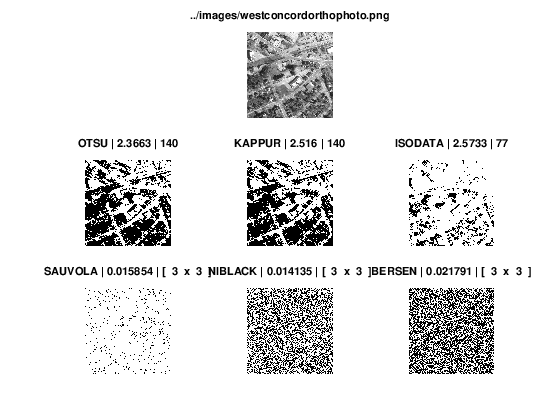

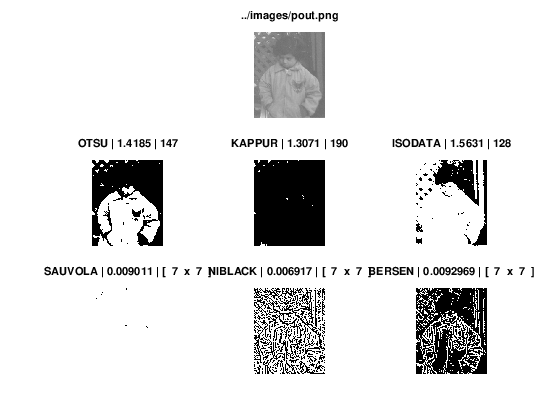

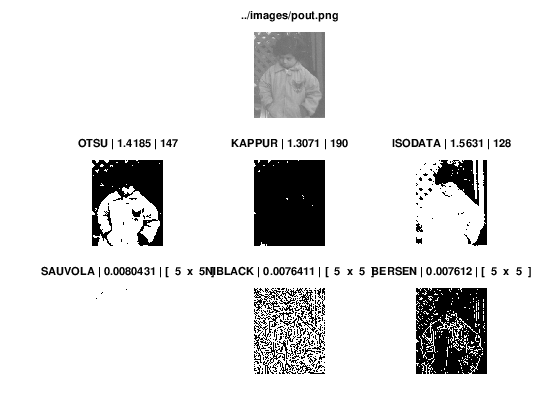

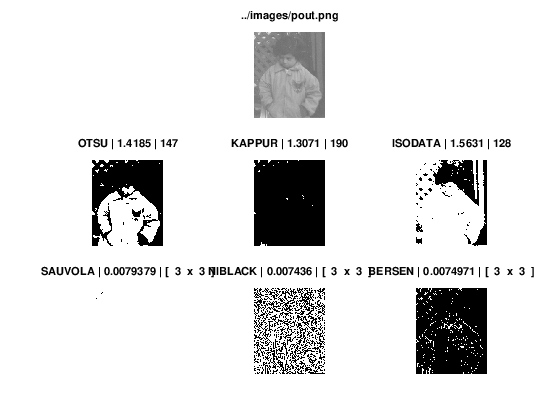

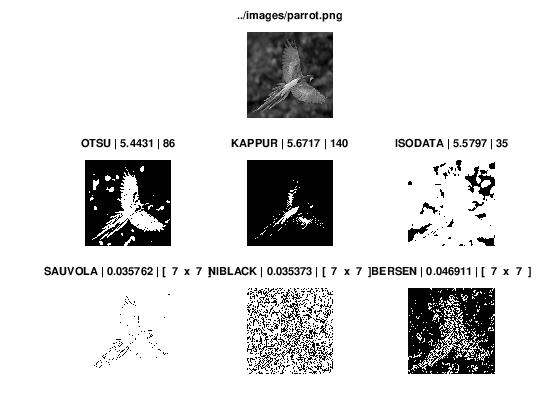

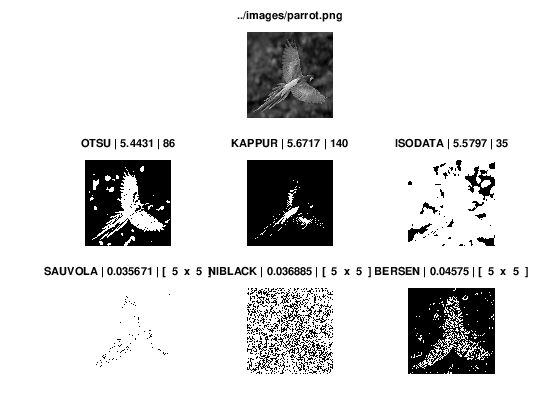

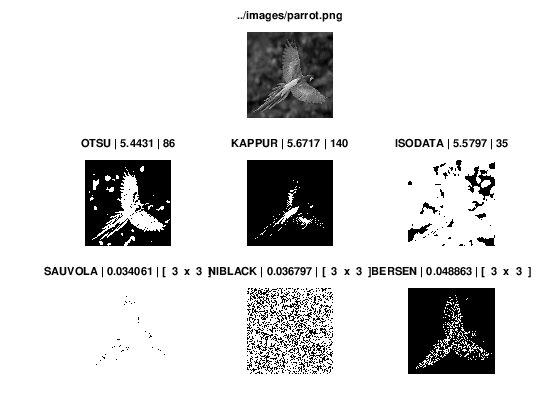

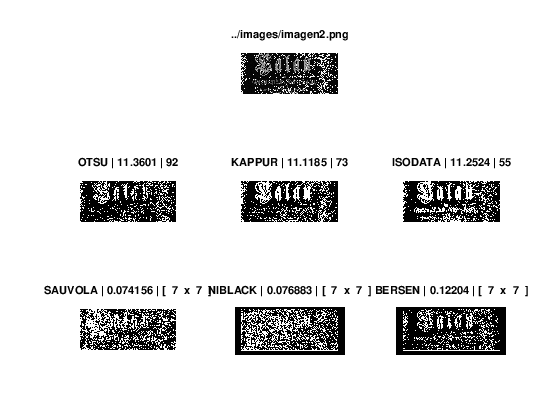

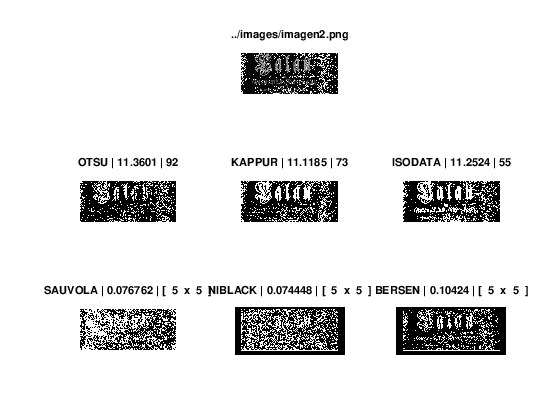

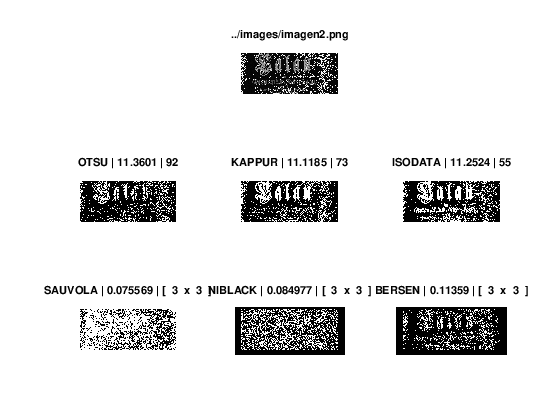

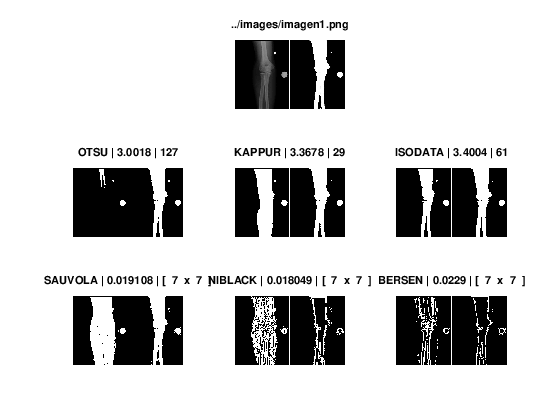

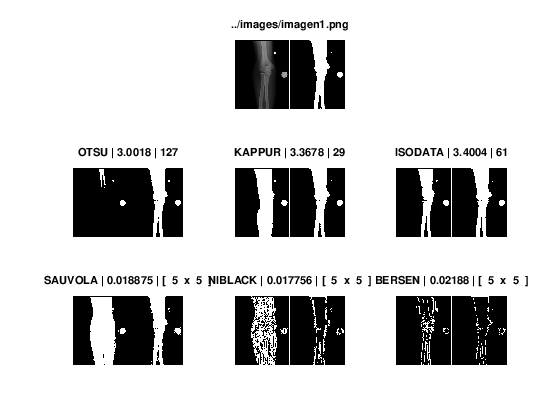

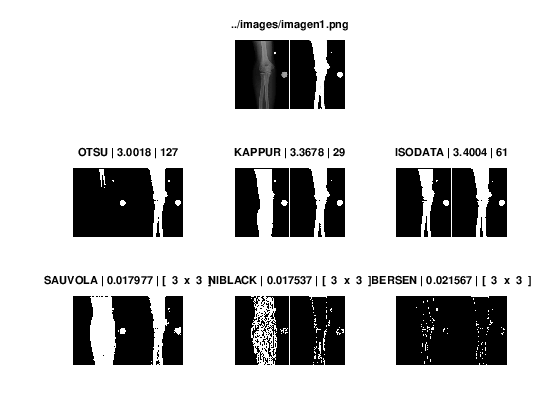

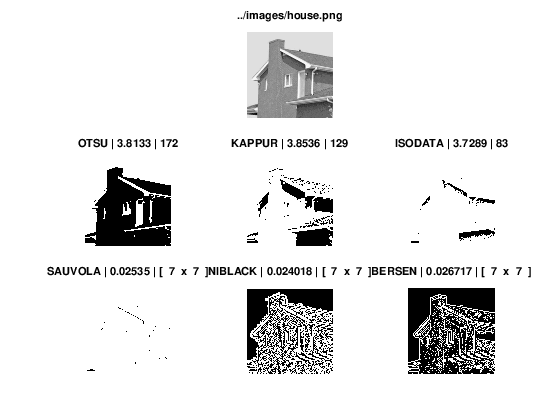

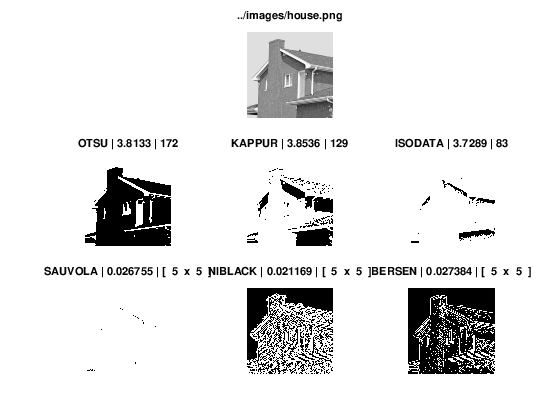

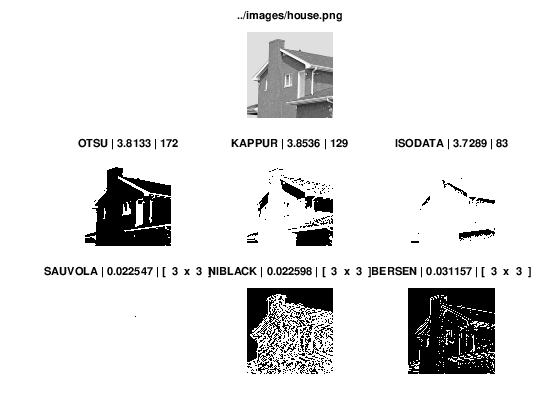

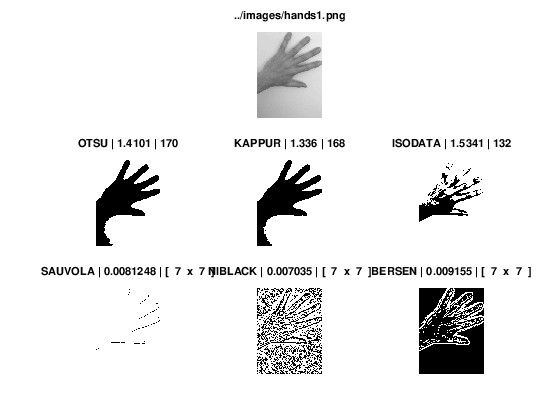

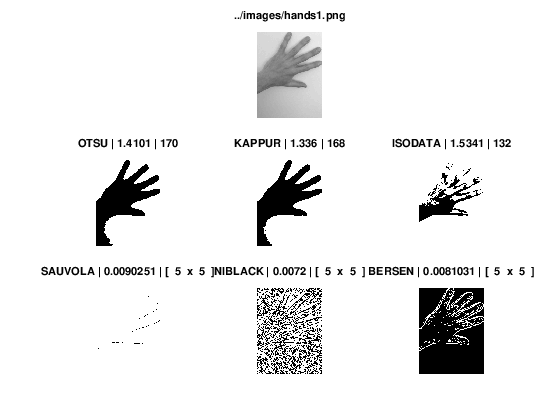

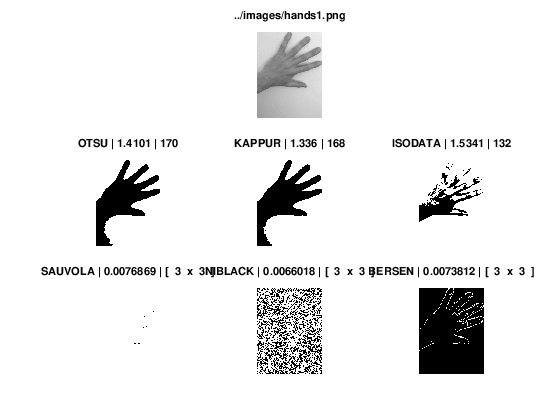

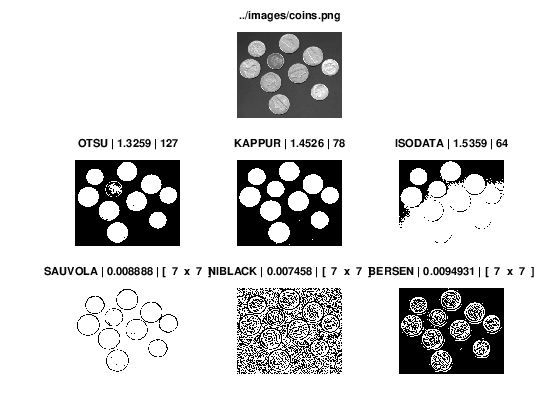

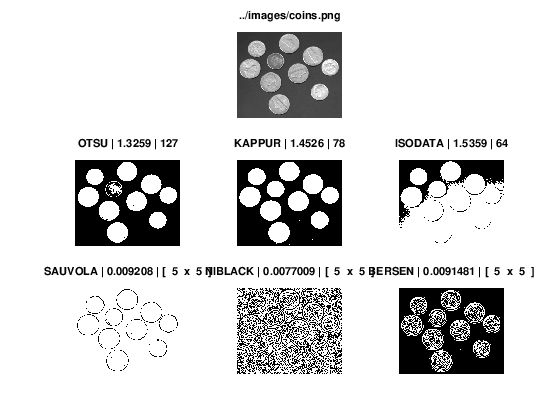

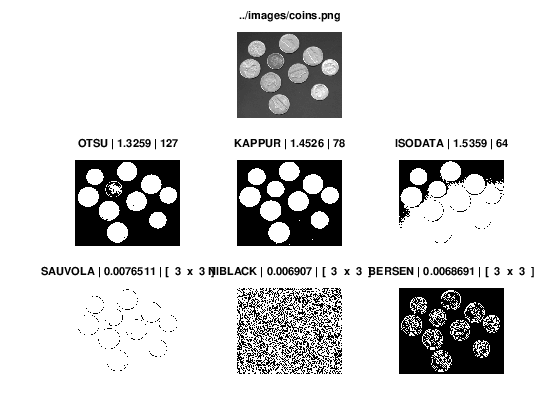

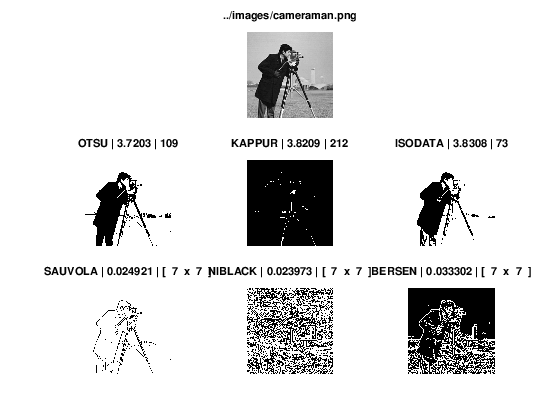

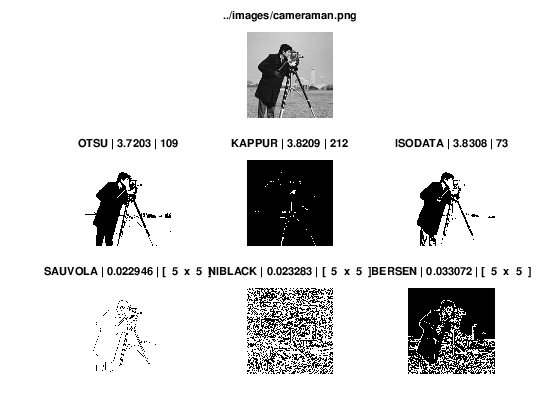

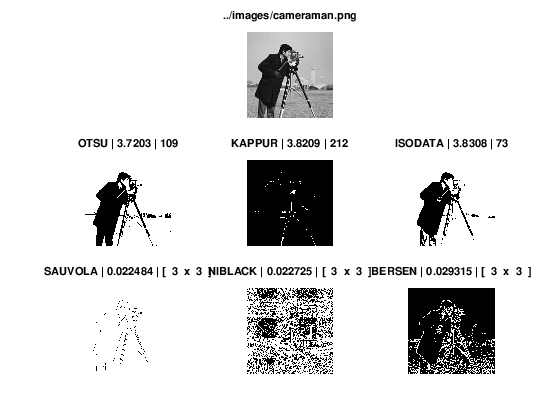

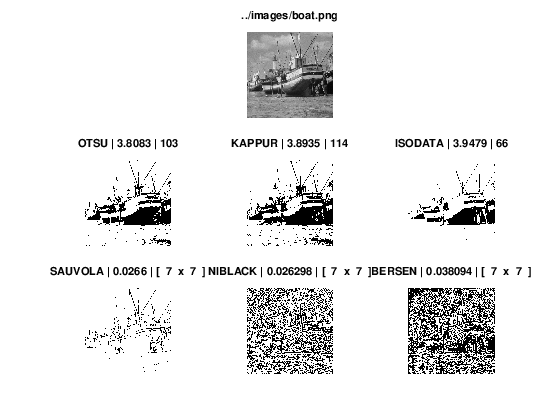

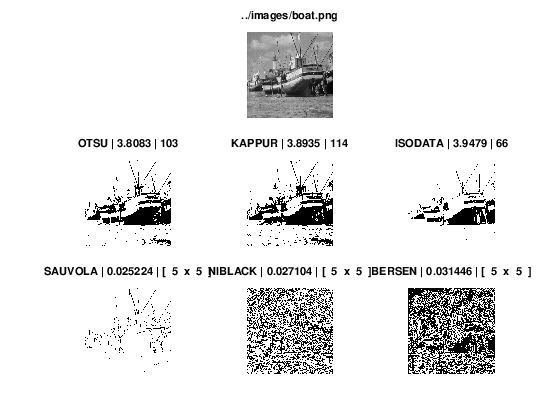

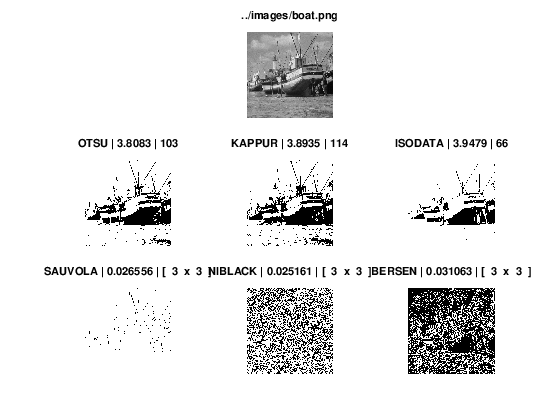

In [22]:
for ii = [1:size(IMGS)(2)]
    filename = IMGS{ii};
    
    current = strcat(PATH, strcat("/", filename));
    imCurrent = imread(current);
    
    [a,b,c]=size(imCurrent);
    if c~=1
        imCurrent=toGray(imCurrent);
    end
    
    % Metodos Globales
    % 
    % OTSU
       
    tic;
    OTSU_T = otsu(imCurrent);
    OTSU_IMG = Binarization(imCurrent, OTSU_T);
    OTSU_t = toc;
    OTSU_LABEL = strjoin({"OTSU", num2str(OTSU_t), int2str(OTSU_T)}, " | ");
    
    partial_results = [OTSU_t];
    
    % Kappur
    
    tic;
    KAPPUR_T = kapurMethod(imCurrent);
    KAPPUR_IMG = Binarization(imCurrent, KAPPUR_T);
    KAPPUR_t = toc;
    KAPPUR_LABEL = strjoin({"KAPPUR", num2str(KAPPUR_t), int2str(KAPPUR_T)}, " | ");
    
    partial_results = [partial_results, KAPPUR_t];
    
    % Isodata
    
    tic;
    ISODATA_T = isodata(imCurrent);
    ISODATA_IMG = Binarization(imCurrent, ISODATA_T);
    ISODATA_t = toc;
    ISODATA_LABEL = strjoin({"ISODATA", num2str(ISODATA_t), int2str(ISODATA_T)}, " | ");
    
    partial_results = [partial_results, ISODATA_t];
    
    % Metodos Locales
    %
    
    ref = 1;
    for jj = [3:2:7]
        % Sauvola
        filterShape = [jj jj];
        filterSTR = strjoin({"[ ", int2str(jj), " x ", int2str(jj), " ]"});

        tic;
        SAUVOLA_IMG = sauvola(imCurrent, filterShape);
        SAUVOLA_t = toc;
        SAUVOLA_LABEL = strjoin({"SAUVOLA", num2str(SAUVOLA_t), filterSTR}, " | ");
        
        partial_results = [partial_results, SAUVOLA_t];
        
        % Niblack

        tic;
        NIBLACK_IMG = niblack(imCurrent, filterShape);
        NIBLACK_t = toc;
        NIBLACK_LABEL = strjoin({"NIBLACK", num2str(NIBLACK_t), filterSTR}, " | ");

        partial_results = [partial_results, NIBLACK_t];

        % Bernsen

        tic;
        BERSEN_IMG = bernsen(imCurrent, filterShape);
        BERSEN_t = toc;
        BERSEN_LABEL = strjoin({"BERSEN", num2str(BERSEN_t), filterSTR}, " | "); 
        
        partial_results = [partial_results, BERSEN_t];
        
        % SHOWING

        figure;

        subplot(3,3,2); imshow(imCurrent); title(current);

        subplot(3,3,4); imshow(OTSU_IMG); title(OTSU_LABEL);

        subplot(3,3,5); imshow(KAPPUR_IMG); title(KAPPUR_LABEL);

        subplot(3,3,6); imshow(ISODATA_IMG); title(ISODATA_LABEL);

        subplot(3,3,7); imshow(SAUVOLA_IMG); title(SAUVOLA_LABEL);

        subplot(3,3,8); imshow(NIBLACK_IMG); title(NIBLACK_LABEL);

        subplot(3,3,9); imshow(BERSEN_IMG); title(BERSEN_LABEL);

        saveas((ii - 1) * 3 + ref, strjoin({"./results/RE_FA", int2str(ii), "-", int2str(jj), "_", filename}, ""), "png");
        
        ref = ref + 1;
    end
    
    results(ii, :) = partial_results;
end

#### Tiempos de Ejecucion

In [23]:
results

results =

 Columns 1 through 6:

    3.8083231    3.8935239    3.9478810    0.0265560    0.0251610    0.0310631
    3.7202699    3.8208930    3.8307579    0.0224838    0.0227251    0.0293150
    1.3259499    1.4525571    1.5359390    0.0076511    0.0069070    0.0068691
    1.4100649    1.3360400    1.5340919    0.0076869    0.0066018    0.0073812
    3.8133199    3.8536358    3.7288752    0.0225470    0.0225980    0.0311570
    3.0017850    3.3677831    3.4003789    0.0179770    0.0175369    0.0215671
   11.3601019   11.1185050   11.2524040    0.0755689    0.0849769    0.1135900
    5.4430840    5.6717348    5.5796869    0.0340610    0.0367970    0.0488629
    1.4185028    1.3070779    1.5630691    0.0079379    0.0074360    0.0074971
    2.3663411    2.5160251    2.5732949    0.0158541    0.0141349    0.0217910

 Columns 7 through 12:

    0.0252240    0.0271039    0.0314460    0.0266001    0.0262980    0.0380940
    0.0229461    0.0232830    0.0330720    0.0249212    0.0239730    0.0

In [24]:
csvwrite('./results/times.csv', results)